## 0. Preliminary imports

In [15]:
import pandas as pd
import numpy as np
import torch
import nltk
from sklearn.preprocessing import LabelEncoder
from transformers import CamembertTokenizer, CamembertForSequenceClassification, FlaubertTokenizer, FlaubertForSequenceClassification, CamembertModel, FlaubertModel
from torch.utils.data import DataLoader, Dataset
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import tqdm
nltk.download('punkt')
nltk.download('stopwords')

# Load French stopwords
stop_words = set(stopwords.words('french'))
color = 'pink'


[nltk_data] Downloading package punkt to /Users/vaienti/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vaienti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Read and clean the training data
We read the training data (training_data.csv), remove the rows with missing values, drop the duplicate rows and reset the index.

The training data contains sentences ('sentence') and their corresponding A1, ..., C2 label for the difficulty ('difficulty').

In [2]:
# we read the training data
df = pd.read_csv('../training/training_data.csv')
# Drop rows with missing 'sentence' or 'difficulty' in training data
df = df.dropna(subset=['sentence', 'difficulty'])
# remove duplicates
df = df.drop_duplicates(subset=['sentence'])
df.reset_index(drop=True, inplace=True)

## 2. Read the test data
In this case we don't drop any columns, since we want to predict the difficulty of all the sentences. We won't do any data cleaning.

In [3]:
# Load the test dataset
inference = pd.read_csv('../test/unlabelled_test_data.csv')

## 3. Data Augmentation
We will enhance our dataset by adding additional features deriving from the original text. We will use the following features:
- **Number of words** in each sentence ('n_words');
- **Average word length** in each sentence excluding stopwords ('avg_word_length');
- **Part-of-Speech (POS) tags** representing the syntactic role of each word in the sentence and the frequency of each tag;


(- **Cognates** - similar words between french and english which could influence the perceived difficulty of the sentence;)


We will add these features, if relevant, to the training and test data.

### 3.1 Number of words

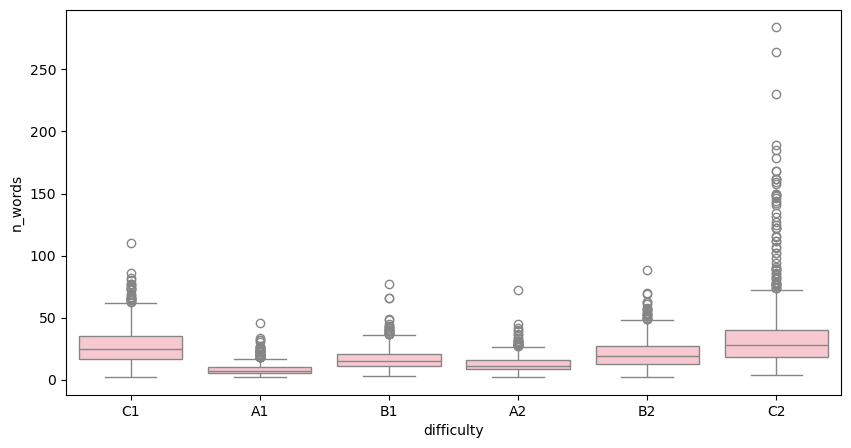

In [4]:
# 1. we add a column with the number of words in the text ('sentence' column)

def add_n_words(df):
    df['n_words'] = df['sentence'].apply(lambda x: len(word_tokenize(x)))
    return df

df = add_n_words(df)
inference = add_n_words(inference)

# let's visualize the correlation between the number of words and the difficulty
plt.figure(figsize=(10, 5))
sns.boxplot(x='difficulty', y='n_words', data=df, color = color)
plt.show()


There is a correlation between the number of words in a sentence and the difficulty of the sentence, so this feature could be useful.


### 3.2 Average word length
Calculated after removing stopwords.

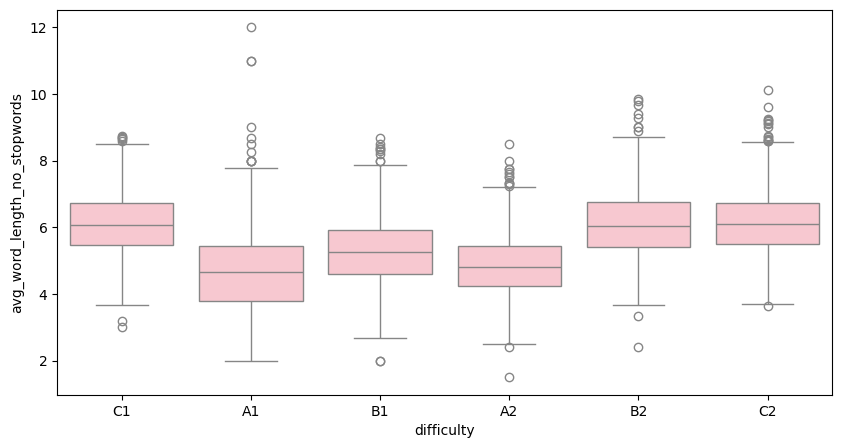

In [5]:
# Function to calculate average word length excluding stopwords
def avg_word_length_no_stopwords(sentence):
    words = word_tokenize(sentence)
    words_no_stopwords = [word for word in words if word.lower() not in stop_words]
    if len(words_no_stopwords) > 0:
        avg_length = sum(len(word) for word in words_no_stopwords) / len(words_no_stopwords)
    else:
        avg_length = 0  # To handle cases where all words are stopwords
    return avg_length

def add_avg_word_length_no_stopwords(df):
    df['avg_word_length_no_stopwords'] = df['sentence'].apply(avg_word_length_no_stopwords)
    return df

df = add_avg_word_length_no_stopwords(df)
inference = add_avg_word_length_no_stopwords(inference)

# let's visualize the correlation between the average word length and the difficulty
plt.figure(figsize=(10, 5))
sns.boxplot(x='difficulty', y='avg_word_length_no_stopwords', data=df, color = color)
plt.show()


There is a correlation between the average word lenght and the difficulty, so we will keep this feature.

### 3.3 Part-of-Speech (POS) tags
We analyze the sentences and extract the POS tags for each word (after removing stopwords). Tags represent the syntactic role of each word in the sentence. We calculate the frequency of each tag. 

However, we won't use all the tags, but only the most relevant ones, chosen as the first 10 tags with the highest frequency. 

# todo: see if the pos tagging is better with camembert

Top POS tags: ['NN', 'JJ', 'NNS', ',', '.', 'NNP', 'VBP', 'VBZ', 'DT', 'CD']


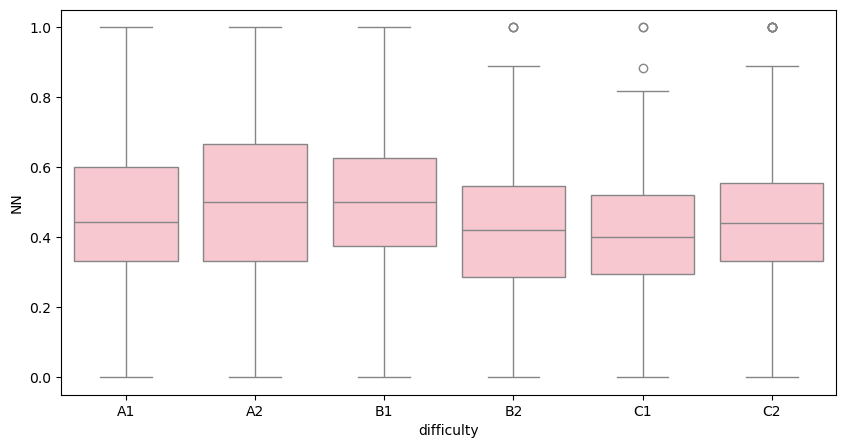

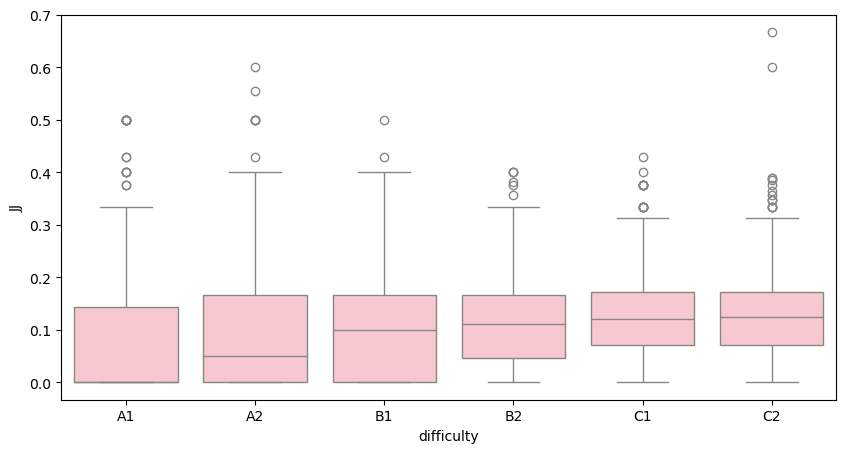

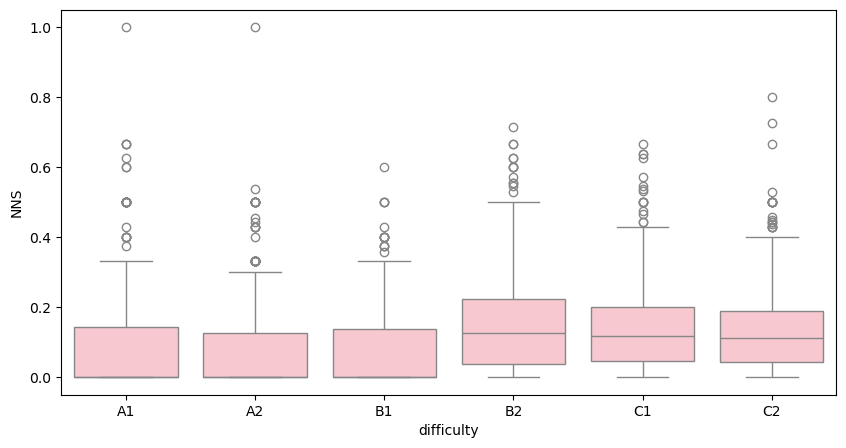

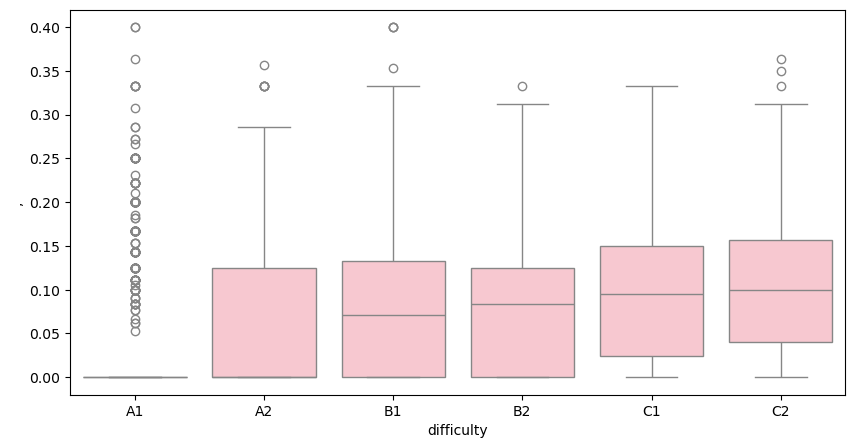

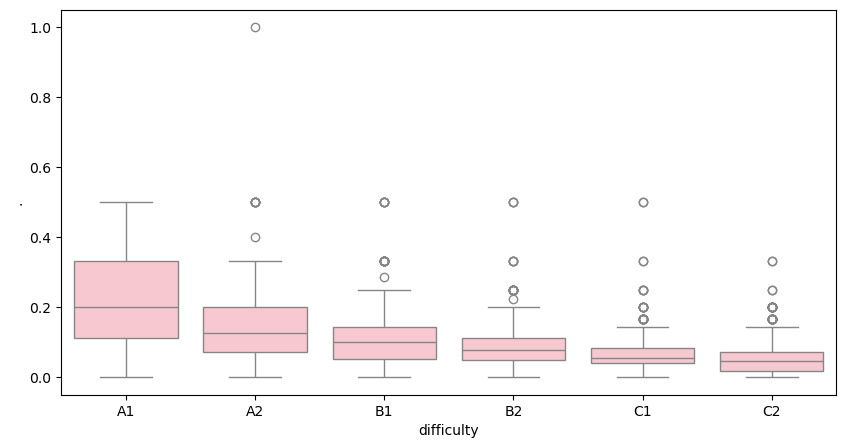

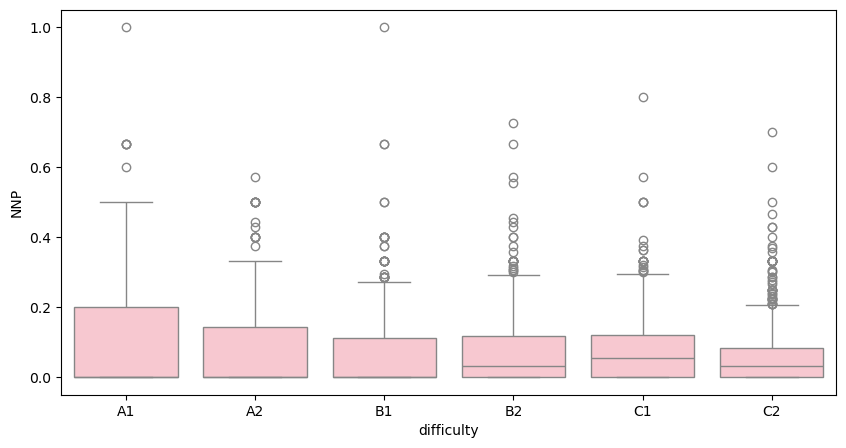

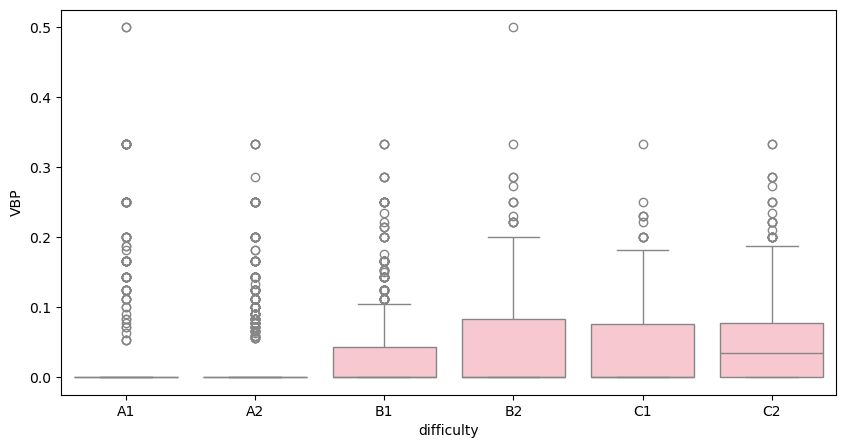

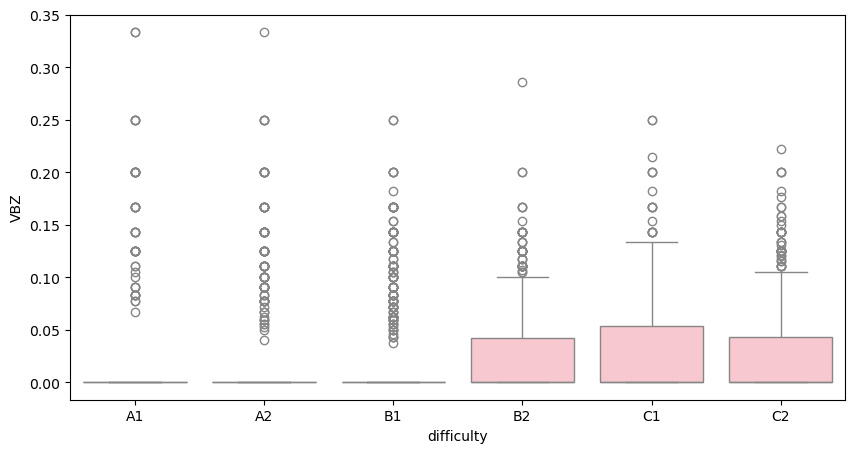

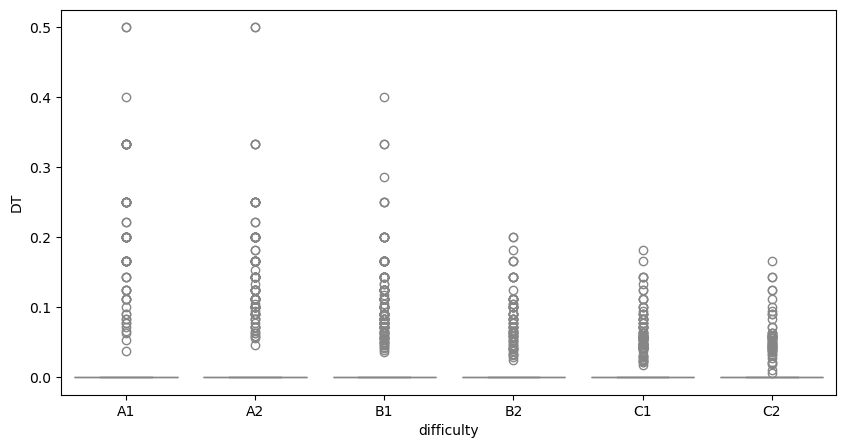

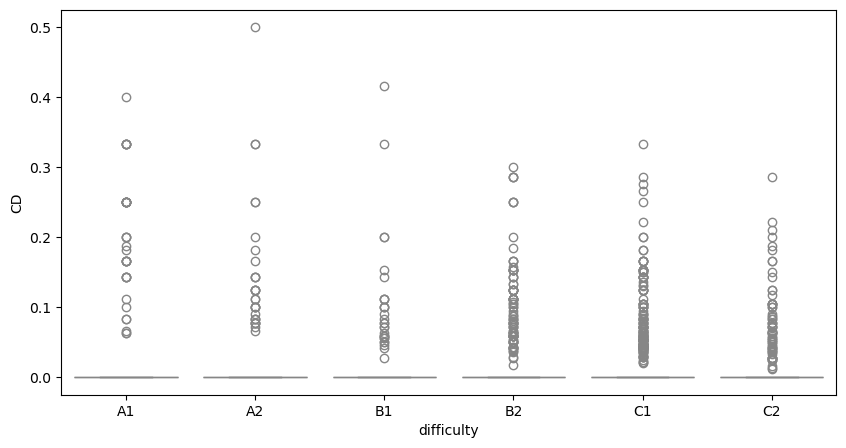

In [6]:
# Function to calculate frequencies of POS tags in a sentence, excluding specific tags
def get_tag_counts(sentences, exclude_tags={}):
    tag_counts = defaultdict(int)
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        tokens_no_stopwords = [word for word in tokens if word.lower() not in stop_words]
        pos_tags = pos_tag(tokens_no_stopwords)
        for _, tag in pos_tags:
            if tag not in exclude_tags:
                tag_counts[tag] += 1
    return tag_counts

def pos_counts(sentence, top_tags, exclude_tags=None):
    if exclude_tags is None:
        exclude_tags = {}  # Include typical punctuation to exclude by default
    tokens = word_tokenize(sentence)
    tokens_no_stopwords = [word for word in tokens if word.lower() not in stop_words]
    pos_tags = pos_tag(tokens_no_stopwords)
    pos_counts = defaultdict(int)
    total_counts = 0

    # Count only relevant POS tags
    for _, tag in pos_tags:
        if tag not in exclude_tags and tag in top_tags:
            pos_counts[tag] += 1
            total_counts += 1

    # Convert counts to frequencies, safely handling division by zero
    pos_frequencies = {tag: (pos_counts[tag] / total_counts if total_counts > 0 else 0) for tag in top_tags}
    return pos_frequencies

def add_pos_counts(df, top_tags):
    # Apply the function to the DataFrame
    df['pos_counts'] = df['sentence'].apply(lambda x: pos_counts(x, top_tags))

    # Expand the pos_counts dictionary into separate columns
    for tag in top_tags:
        df[tag] = df['pos_counts'].apply(lambda x: x.get(tag, 0))
    
    # Drop the pos_counts column if no longer needed
    df.drop(columns=['pos_counts'], inplace=True)
    
    return df

all_sentences = df['sentence'].tolist() + inference['sentence'].tolist()  # Combining sentences from both datasets
total_tag_counts = get_tag_counts(all_sentences)  # Exclude punctuation

# Select the top N most frequent tags, e.g., top 10
top_tags = sorted(total_tag_counts.items(), key=lambda x: x[1], reverse=True)[:10]
top_tags = [tag for tag, count in top_tags]
print("Top POS tags:", top_tags)

# Apply the function to the test and training datasets
df = add_pos_counts(df, top_tags)
inference = add_pos_counts(inference, top_tags)

# Let's visualize the correlation between the top POS tags and the difficulty
difficulty_order = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']  
for tag in top_tags:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='difficulty', y=tag, data=df, order=difficulty_order, color = color)
    plt.show()

### 3.4 Cognates > not implemented - I didn't find a list to use
We will use a list of cognates (similar words between french and english) to create a new feature. We will count the frequency of cognates in each sentence.

## 4. Processing of the sentences (generation of embeddings)
After adding the new features, we will process the sentences in order to be able to use them in the model and to improve the model's performance. In particular we want to create embeddings for the sentences using the CamemBERT/FlauBERT model.


We will:
- Apply tokenization using the CamemBERT/FlauBERT tokenizer;
- Pad the sequences to the same length;
- Create the attention masks;
- Create the embeddings for the sentences using the CamemBERT/FlauBERT model.

Since we are using CamemBERT and FlauBERT, we won't apply lemmatization or stemming, or remove stopwords, since these models are working with contextual words.



### 4.1 Selection of the model and tokenizer
First, we need to choose the model between 'camembert' and 'flaubert'. 

In [10]:
chosen_tokenizer = 'camembert'

def get_tokenizer_model(chosen_tokenizer, num_classes):
    if chosen_tokenizer == 'camembert':
        tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
        model = CamembertModel.from_pretrained('camembert-base', num_labels=num_classes)
    elif chosen_tokenizer == 'flaubert':
        tokenizer = FlaubertTokenizer.from_pretrained('flaubert/flaubert_base_cased')
        model = FlaubertModel.from_pretrained('flaubert/flaubert_base_cased', num_labels=num_classes)
    return tokenizer, model

num_classes = df['difficulty'].nunique()
tokenizer, model = get_tokenizer_model(chosen_tokenizer, num_classes)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### 4.2 Creating the embeddings
To apply the tokenizer, the padding and the attention masks we create a class CEFRDataset that will be used to process the training and test datasets and to convert the sentences into embeddings.

In [20]:
def get_embeddings(text):
    # Tokenize the text, with padding and truncation
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    
    # Ensure we include the attention mask in the model input
    with torch.no_grad():
        output = model(input_ids=encoded_input['input_ids'], 
                       attention_mask=encoded_input['attention_mask'])
    
    # Extract the embeddings of the [CLS] token, which is at index 0
    return output.last_hidden_state[:, 0, :].squeeze().numpy()

# Apply to your sentences
# since it could be quite long we apply it to batches (to use parallel processing)
def batched_embeddings(texts, batch_size=32):
    # Container for embeddings
    all_embeddings = []

    # Process texts in batches
    for i in tqdm.tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, max_length=128, return_tensors='pt')
        with torch.no_grad():
            output = model(**encoded_input)
        embeddings = output.last_hidden_state[:, 0, :].squeeze().detach().numpy()
        all_embeddings.append(embeddings)

    # Concatenate all batch embeddings
    return np.vstack(all_embeddings)

# Assuming df['sentence'] is a list of texts
embeddings = batched_embeddings(df['sentence'].tolist())
df['embeddings'] = embeddings.tolist()

# Apply to the test dataset
inference_embeddings = batched_embeddings(inference['sentence'].tolist())
inference['embeddings'] = inference_embeddings.tolist()

100%|██████████| 38/38 [00:23<00:00,  1.65it/s]


In [19]:
# we have a look at the df right now:
df.head()

,id,sentence,difficulty,n_words,avg_word_length_no_stopwords,NN,JJ,NNS,",",.,NNP,VBP,VBZ,DT,CD,embeddings
0,0,Les coûts kilométriques réels peuvent diverger...,C1,44,6.379310,0.535714,0.107143,0.107143,0.178571,0.035714,0.000000,0.035714,0.000000,0.0,0.000000,"[0.07098422944545746, 0.09660283476114273, 0.0..."
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,14,4.500000,0.500000,0.125000,0.000000,0.125000,0.125000,0.000000,0.125000,0.000000,0.0,0.000000,"[-0.05412760749459267, -0.06828022003173828, 0..."
2,2,Le test de niveau en français est sur le site ...,A1,14,5.428571,0.714286,0.000000,0.000000,0.000000,0.142857,0.142857,0.000000,0.000000,0.0,0.000000,"[0.012144934386014938, 0.03654233366250992, 0...."
3,3,Est-ce que ton mari est aussi de Boston?,A1,9,4.400000,0.250000,0.250000,0.000000,0.000000,0.250000,0.250000,0.000000,0.000000,0.0,0.000000,"[-0.004021527245640755, 0.02219346910715103, 0..."
4,4,"Dans les écoles de commerce, dans les couloirs...",B1,39,5.708333,0.318182,0.136364,0.227273,0.090909,0.045455,0.000000,0.000000,0.090909,0.0,0.090909,"[0.02371220290660858, -0.02964732050895691, 0...."


In [21]:
inference.head()

,id,sentence,n_words,avg_word_length_no_stopwords,NN,JJ,NNS,",",.,NNP,VBP,VBZ,DT,CD,embeddings
0,0,Nous dûmes nous excuser des propos que nous eû...,10,6.750000,0.500000,0.000000,0.25,0.000000,0.000000,0.000000,0.250000,0.000000,0.0,0.0,"[0.04623586684465408, 0.13113509118556976, 0.1..."
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...,15,5.555556,0.888889,0.000000,0.00,0.000000,0.111111,0.000000,0.000000,0.000000,0.0,0.0,"[-0.06660883873701096, -0.014503978192806244, ..."
2,2,"Et, paradoxalement, boire froid n'est pas la b...",12,4.777778,0.625000,0.000000,0.00,0.250000,0.125000,0.000000,0.000000,0.000000,0.0,0.0,"[0.0031737228855490685, 0.03613223135471344, 0..."
3,3,"Ce n'est pas étonnant, car c'est une saison my...",10,5.571429,0.800000,0.000000,0.00,0.200000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,"[-0.024849681183695793, 0.0032904967665672302,..."
4,4,"Le corps de Golo lui-même, d'une essence aussi...",78,6.384615,0.714286,0.102041,0.00,0.102041,0.020408,0.020408,0.020408,0.020408,0.0,0.0,"[0.046980034559965134, 0.11302952468395233, -0..."


# 5. Preprocessing of the target variable
## Label encoding of the target variable
The target variable contains the difficulty levels as strings (A1, A2, B1, B2, C1, C2). We convert these strings to integers using the LabelEncoder from the scikit-learn library.

In [23]:
y = df['difficulty'].values

# Define the order of your labels
labels_ordered = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Manually fit the encoder to the ordered labels
encoder.fit(labels_ordered)

# Encode your actual labels
y_encoded = encoder.transform(y)

# Output the encoding to verify
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Label mapping:", label_mapping)
print(y, y_encoded)

Label mapping: {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
['C1' 'A1' 'A1' ... 'A2' 'C2' 'C2'] [4 0 0 ... 1 5 5]


## 6. Model architecture

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class SentenceDifficultyPredictor(nn.Module):
    def __init__(self, embedding_dim, num_features, hidden_dim, output_dim):
        super(SentenceDifficultyPredictor, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_features = num_features
        self.hidden_dim = hidden_dim
        
        # Embedding layer
        self.embedding_fc = nn.Linear(embedding_dim, hidden_dim)
        
        # Additional features layer
        self.features_fc = nn.Linear(num_features, hidden_dim)
        
        # Combined layer
        self.combined_fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.combined_fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, embeddings, features):
        # Pass through embedding layer
        embedded = F.relu(self.embedding_fc(embeddings))
        
        # Pass through features layer
        features_output = F.relu(self.features_fc(features))
        
        # Concatenate embeddings and features
        combined = torch.cat((embedded, features_output), dim=1)
        
        # Pass through combined layer
        combined = F.relu(self.combined_fc1(combined))
        output = self.combined_fc2(combined)
        
        return output

## 7. Training the model


In [34]:
embeddings_array = np.vstack(df['embeddings'].values)
excluded_columns_training = ['id', 'sentence', 'difficulty', 'embeddings']
feature_columns = [col for col in df.columns if col not in excluded_columns_training]
additional_features = df[feature_columns].values
#we apply a scaler to the additional features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
additional_features = scaler.fit_transform(additional_features)
# Define the model
# Combine embeddings and other features
X = np.hstack((embeddings_array, additional_features))

# Target variable (already encoded)
y = y_encoded

excluded_columns_inference= ['id', 'sentence', 'embeddings']
inference_embeddings_array = np.vstack(inference['embeddings'].values)
inference_feature_columns = [col for col in inference.columns if col not in excluded_columns_inference]
inference_additional_features = inference[inference_feature_columns].values
# Apply the same scaler to the additional features
inference_additional_features = scaler.transform(inference_additional_features)
# Combine embeddings and other features
X_inference = np.hstack((inference_embeddings_array, inference_additional_features))

### 7.1 (optional) 20% validation split
We split the training data into training and validation data (80% training, 20% validation), just to see how the model is performing without any hyperparameter tuning.

In [35]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
# Convert to PyTorch tensors
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))



Training data shape: (3840, 780)
Testing data shape: (960, 780)


### 7.2 Hyperparameter tuning: k-fold cross validation 
to find the best hyperparameters for the model

In [39]:
# Define batch size for the DataLoader
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SentenceDifficultyPredictor(embedding_dim=X_train.shape[1], 
                                    num_features=0,  # Since X_train already includes embeddings and features
                                    hidden_dim=128, 
                                    output_dim=len(np.unique(y))).to(device)
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader)}')

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Test Accuracy: {100 * correct / total:.2f}%')

# Train and evaluate the model
train_model(model, train_loader, optimizer, criterion, epochs=10)
evaluate_model(model, test_loader)

/Users/vaienti/miniforge3/envs/cartogenealogy/lib/python3.12/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


TypeError: SentenceDifficultyPredictor.forward() missing 1 required positional argument: 'features'

In [62]:
#todo
from torch.utils.data import DataLoader
#split the dataset into training and validation datasets (in the future we will do a k-fold cross validation)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
# Define number of folds
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
model.to(device)  # Move model to GPU if available

num_epochs = 5


n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

import torch
import tqdm
from transformers import AdamW, get_scheduler

# Define your learning rate and other hyperparameters
learning_rates = [1e-5, 5e-5, 1e-4]  # Example learning rates to test

# Initialize results container for hyperparameter tuning
hyperparam_results = {}

for lr in learning_rates:
    fold_results = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"Training with lr={lr}, fold {fold+1}/{n_splits}")

        # Split data according to current fold
        train_sentences = df.iloc[train_idx]['sentence'].reset_index(drop=True)
        train_labels = y_encoded[train_idx]
        val_sentences = df.iloc[val_idx]['sentence'].reset_index(drop=True)
        val_labels = y_encoded[val_idx]

        # Create datasets
        train_dataset = CEFRDataset(train_sentences, tokenizer, max_len=128, labels=train_labels)
        val_dataset = CEFRDataset(val_sentences, tokenizer, max_len=128, labels=val_labels)

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

        # Initialize model and move it to the device
        model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=len(np.unique(y_encoded)))
        model.to(device)

        # Initialize optimizer and scheduler
        optimizer = AdamW(model.parameters(), lr=lr)
        num_training_steps = num_epochs * len(train_loader)
        lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

        # Training loop
        model.train()
        for epoch in range(num_epochs):
            for batch in tqdm.tqdm(train_loader, desc=f"Epoch {epoch + 1} Training"):
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

        # Validation loop
        total_eval_accuracy = 0
        model.eval()
        for batch in tqdm.tqdm(val_loader, desc="Validating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            accuracy = (predictions == batch['labels']).float().mean()
            total_eval_accuracy += accuracy.item()

        avg_val_accuracy = total_eval_accuracy / len(val_loader)
        fold_results.append(avg_val_accuracy)
        print(f"Fold {fold+1} validation accuracy: {avg_val_accuracy}")

    # Average accuracy across folds for current learning rate
    average_accuracy = sum(fold_results) / len(fold_results)
    hyperparam_results[lr] = average_accuracy
    print(f"Average validation accuracy with lr={lr}: {average_accuracy}")

# Identify best performing hyperparameters
best_lr = max(hyperparam_results, key=hyperparam_results.get)
print(f"Best learning rate: {best_lr} with an average validation accuracy of {hyperparam_results[best_lr]}")

# hyperparameter tuning


Using cpu device
Training with lr=1e-05, fold 1/5


KeyboardInterrupt: 

In [65]:
from sklearn.metrics import classification_report, confusion_matrix
#first maybe we need to train the model with the best hyperparameters on a 20% validation set
# Split data into training and validation sets
best_lr = 1e-5
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    df['sentence'], y_encoded, test_size=0.1, random_state=100)

train_dataset = CEFRDataset(train_sentences, tokenizer, max_len=128, labels=train_labels)
val_dataset = CEFRDataset(val_sentences, tokenizer, max_len=128, labels=val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=len(np.unique(y_encoded)))
model.to(device)
optimizer = AdamW(model.parameters(), lr=best_lr)

model.train()
for epoch in range(num_epochs):
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

model.eval()
true_labels = []
predicted_labels = []
for batch in val_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    true_labels.extend(batch['labels'].cpu().numpy())
    predicted_labels.extend(predictions.cpu().numpy())

print(classification_report(true_labels, predicted_labels))
print(confusion_matrix(true_labels, predicted_labels))

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/vaienti/miniforge3/envs/cartogenealogy/lib/python3.12/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/Users/vaienti/miniforge3/envs/cartogenealogy/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest seq

KeyError: 1176

In [ ]:
#todo : train on the full dataset and save the model!!!
full_dataset = CEFRDataset(df['sentence'], tokenizer, max_len=128, labels=y_encoded)
full_loader = DataLoader(full_dataset, batch_size=16, shuffle=True)
optimizer = AdamW(model.parameters(), lr=best_lr)
num_training_steps = num_epochs * len(full_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

model.train()
for epoch in range(num_epochs):
    for batch in tqdm.tqdm(full_loader, desc=f"Training Epoch {epoch+1}"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

In [53]:
model_path = "/Users/vaienti/Library/CloudStorage/OneDrive-epfl.ch/2024_courses/data_science_and_machine_learning/models/"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)


('/Users/vaienti/Library/CloudStorage/OneDrive-epfl.ch/2024_courses/data_science_and_machine_learning/models/tokenizer_config.json',
 '/Users/vaienti/Library/CloudStorage/OneDrive-epfl.ch/2024_courses/data_science_and_machine_learning/models/special_tokens_map.json',
 '/Users/vaienti/Library/CloudStorage/OneDrive-epfl.ch/2024_courses/data_science_and_machine_learning/models/sentencepiece.bpe.model',
 '/Users/vaienti/Library/CloudStorage/OneDrive-epfl.ch/2024_courses/data_science_and_machine_learning/models/added_tokens.json')

In [57]:
import torch
from torch.utils.data import DataLoader

# Assuming the model and tokenizer are already loaded and set up


test_sentences = test['sentence'].reset_index(drop=True)
test_dataset = CEFRDataset(test_sentences, tokenizer, max_len=128)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Run inference
predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=1)
        
        predictions.extend(pred.cpu().numpy())

# Decode predictions
decoded_predictions = encoder.inverse_transform(predictions)

# Add decoded predictions to the DataFrame
test['predicted_labels'] = decoded_predictions
import copy
test_results = copy.deepcopy(test)
test_results = test_results.drop(columns=['sentence'])
test_results = test_results.rename(columns={'predicted_labels': 'difficulty'})
test_results.to_csv('../kaggle_submissions/test_with_predictions.csv', index=False)


/Users/vaienti/miniforge3/envs/cartogenealogy/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Inference complete. Results saved to 'test_with_predictions.csv'.


## 1. Lemmatization of the sentences

Create tokenizer and model

Separate the data into train and test:

In [5]:
from transformers import CamembertTokenizer, CamembertForSequenceClassification, FlaubertTokenizer, FlaubertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
# 1) tokenization > used to encode the sentences
# we could do the tokenization either with Camembert or Flaubert
# 2) padding > used to make all the sentences of the same length
# 3) attention masks > to give the same weight to all the words, regardless of their length
num_classes = df['difficulty'].nunique()
chosen_tokenizer = 'camembert'

if chosen_tokenizer == 'camembert':
    tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
    model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=num_classes)
elif chosen_tokenizer == 'flaubert':
    tokenizer = FlaubertTokenizer.from_pretrained('flaubert/flaubert_base_cased')
    model = FlaubertForSequenceClassification.from_pretrained('flaubert/flaubert_base_cased', num_labels=num_classes)

tokenized = X_train.apply((lambda x_: tokenizer.encode(x_, add_special_tokens=True)))
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)
# now we load the data into a torch dataloader 
# respecting the input expected by the BERT model

input_ids = torch.tensor(padded)
#create the attention mask copying with sourceTensor.clone()
attention_mask_tensor = torch.tensor(attention_mask)
labels = torch.tensor(y_train)
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
dataset = TensorDataset(input_ids, attention_mask_tensor, labels)
dataloader = DataLoader(dataset, batch_size=32)
from transformers import  get_linear_schedule_with_warmup
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader)*epochs)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# training loop
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
epochs = 1
for epoch in range(1, epochs+1):
    model.train()
    loss_train_total = 0
    progress_bar = tqdm(dataloader, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        outputs = model(**inputs)
        loss = outputs.loss
        loss_train_total += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch[0]))})
    torch.save(model.state_dict(), f'BERT_ft_epoch{epoch}.model')
    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total/len(dataloader)
    tqdm.write(f'Training loss: {loss_train_avg}')


Epoch 1
Training loss: 1.6941598991552989


Predicting Levels
We can now use our model to predict the level of a text. To do this, we need to correctly encode our text in the same way as our data was encoded during training.

In [9]:
def predict_text(text, device):
    encoded_text = tokenizer.encode_plus(
        text,
        max_length=128,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output[0], dim=1)
    return prediction[0].item()

y_pred = []
for text in tqdm(X_test):
    y_pred.append(predict_text(text, device))
    
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['A1', 'A2', 'B1', 'B2', 'C1', 'C2']))

  0%|          | 0/960 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/vaienti/miniforge3/envs/cartogenealogy/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 960/960 

              precision    recall  f1-score   support

          A1       0.42      0.94      0.58       166
          A2       0.29      0.15      0.19       158
          B1       0.42      0.10      0.17       166
          B2       0.44      0.12      0.19       153
          C1       0.29      0.11      0.16       152
          C2       0.37      0.83      0.51       165

    accuracy                           0.38       960
   macro avg       0.37      0.37      0.30       960
weighted avg       0.37      0.38      0.30       960

